In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"

data = Data()

data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../dataset/EthanT3/", postfix = "EthanT3", target=target)

data.include(data_path = "../../dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../dataset/EthenT3/", postfix = "EthenT3", target=target)

data.include(data_path = "../../dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

# SetUp descriptor And Normalisation

In [4]:
import pickle

model_path = "../../models/Descriptor"
target = "P"

descriptor_C = pickle.load(open(model_path + "C/" + target + "/descriptor.dump", "rb"))
descriptor_H = pickle.load(open(model_path + "H/" + target + "/descriptor.dump", "rb"))

descriptors = {
    "C": descriptor_C,
    "H": descriptor_H
}

In [5]:
descriptor_H

In [6]:
normalisations = {
    "C": np.load(model_path + "C/" + target + "/normalisation.npy"),
    "H": np.load(model_path + "H/" + target + "/normalisation.npy")
}

# Fetch Networks 

In [7]:
path = model_path

name_C = model_path + "C/" + target + "/C_" + target + ".h5"
name_H = model_path + "H/" + target + "/H_" + target + ".h5"


model_C = keras.models.load_model(name_C)
model_H = keras.models.load_model(name_H)

networks = {
    "C": model_C,
    "H": model_H
}

# Guess Method 

In [8]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu, AbstractDataset
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from pyscf.scf.hf import init_guess_by_wolfsberg_helmholtz


def init_guess_by_ann(mol):
    
    p  = init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()).copy() # TODO set up my own GWH in SCFInitialGuess
    
    for atom_index, atom in enumerate(mol.species):
        
        mask = mol.make_atom_mask(atom_index)
        
        
        G = descriptors[atom].calculate_atom_descriptor(
            atom_index, 
            mol,
            descriptors[atom].number_of_descriptors
        )
        
        G_norm = AbstractDataset.normalize(G, *normalisations[atom])
        
        #f(G)
        f = networks[atom].predict(G.reshape(1, -1))
        
        f_batch = reconstruct_from_triu(
            f,
            N_BASIS[mol.basis][atom]
        )
        
        p[mask] = f_batch.flatten()
        
    return p
        
    

# Analysis 

## Utils 

In [9]:
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    #train=(s_train, p_train),
    train=(data.S[0], data.T[0]),
    validation=(data.S[1], data.T[1]),
    test=(data.S[2], data.T[2]),
    mu=0,
    std=1
)

 ## Execution 

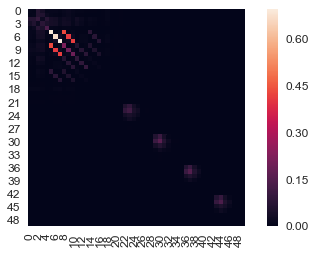

In [12]:
sns.heatmap(np.abs(init_guess_by_ann(data.molecules[2][0]) \
                   - init_guess_by_wolfsberg_helmholtz(data.molecules[2][0].get_pyscf_molecule())), square=True)

In [13]:
p_nn = np.array([
    init_guess_by_ann(mol) for mol in data.molecules[2]
])

## Pure 

In [18]:
from SCFInitialGuess.utilities.analysis import mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg
msg.print_level = 0

    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))


KeyboardInterrupt: 

## Damping 

In [ ]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg
msg.print_level = 0

    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

## DIIS 

In [ ]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg
msg.print_level = 0

    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

# In case only 1 kind of molecule is used 

In [37]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities, mf_initializer
from  SCFInitialGuess.utilities.usermessages import Messenger as msg

msg.print_level=0

print(make_results_str(measure_all_quantities(
    p_nn,
    dataset,
    molecules[2],
    n_electrons,
    mf_initializer,
    dim=dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.15405E-02 +- 8.43906E-03
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
1.15436E-02 +- 8.69451E-04
--- Occupance Error ---
1.51234E+00 +- 3.14587E-01
--- HF Energy Error ---
1.75421E+00 +- 3.01624E-01
--- Avg. Iterations ---
3.46866E+01 +- 1.72089E+01
--- Avg. Iterations W/O Non Converged ---
3.26769E+01 +- 1.30370E+01
--- Num. Not Convd. ---
6

